In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [161]:
def gauss_seidel(A, b, x, tolerance=1e-10, max_iterations=10000):
    iter1 = 0
    for k in range(max_iterations):
        iter1 += 1   
        x_old  = x.copy()
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
        #Stop condition 
        if  max(abs((x - x_old)))/max(abs(x_old)) < tolerance:
            break
    #print("The L infinity norm in iteration", iter1,"is:", max(abs((x - x_old)))/max(abs(x_old)))       
    return x

### Diffusion/Heat Equation

$
\frac{\displaystyle \partial u}{\displaystyle \partial t} = \alpha\nabla^2 u + f 
$

#### Von Neumann stability condition (for explicit)

$
r = \frac{\displaystyle \alpha \Delta t}{\displaystyle (\Delta x)^2} \\
r \le \frac{\displaystyle 1}{\displaystyle 2}
$



In [1118]:
class Heat: 
    def __init__(self, alpha, dx, N, initial_condition, boundary_type = ['Dirichlet','Neumann'], boundary_values=[0, 0], time_integration='implicit'):
        self.alpha = alpha
        self.dx = dx 
        self.N = N  
        self.u_previous = np.array(initial_condition) # For the first time step
        self.boundary_type = boundary_type
        self.boundary_values = boundary_values
        self.time_integration = time_integration 
        self.timestep_count = 0
        if time_integration == 'implicit' or time_integration == 'Crank-Nicolson':
            self.A = np.empty((N,N))
            self.f = np.empty(N)
    
    # Solve the heat equation explicitly  
    def solve_explicit(self, dt, source_term):
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
       
        # initialize u
        u = np.empty(np.shape(self.u_previous))
        
        # Calculate u for elements not in the boundary
        for i in range(1,self.N-1):
            u[i] = self.u_previous[i]+\
                   r*(self.u_previous[i-1]-2*self.u_previous[i]+self.u_previous[i+1])+\
                   dt*source_term[i]     
        
        # Calculate elements in the boundaries 
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            u[0] = self.u_previous[0]+\
                   r*(self.boundary_values[0]-2*self.u_previous[0]+self.u_previous[1])+\
                   dt*source_term[0]     
        elif self.boundary_type[0] == 'Neumann':
            u[0] = self.u_previous[0]+\
                   r*(-self.dx*self.boundary_values[0]-self.u_previous[0]+self.u_previous[1])+\
                   dt*source_term[0]     
        else:
            print('Left boundary: no condition satisfaed!')    
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            u[-1] = self.u_previous[-1]+\
                    r*(self.u_previous[-2]-2*self.u_previous[-1]+self.boundary_values[-1])+\
                    dt*source_term[-1]     
        elif self.boundary_type[1] == 'Neumann':
            u[-1] = self.u_previous[-1]+\
                    r*(self.u_previous[-2]-self.u_previous[-1]+self.dx*self.boundary_values[-1])+\
                    dt*source_term[-1]     
        else:
            print('Left boundary: no condition satisfaed!')      
        
        return u

    # Solve the heat equation fully implicit  
    def solve_implicit(self, dt, source_term):
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
        
        # (Au=f) Calculate matrix A and f 
        ## matrix A
        self.A[:] = np.diag([1+2*r]*self.N,  0)  # Main diagonal
        self.A += np.diag([-r]*(self.N-1), 1)    # Upper diagonal
        self.A += np.diag([-r]*(self.N-1),-1)    # Lower diagonal    
        ## Source term f
        self.f[:] = self.u_previous + dt*np.array(source_term)        
        
        # Calculate boundary conditions 
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            self.f[0] += self.boundary_values[0]*r  
        elif self.boundary_type[0] == 'Neumann':
            self.f[0]  += -self.boundary_values[0]*r*self.dx   
            self.A[0,0] += -r
        else:
            print('Left boundary: no condition satisfaed!')
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            self.f[-1] += self.boundary_values[-1]*r
        elif self.boundary_type[1] == 'Neumann':
            self.f[-1] += self.boundary_values[-1]*r*self.dx  
            self.A[-1,-1] += -r
        else:
            print('Right boundary: no condition satisfaed!')
         
        # Calculate u from Au=f
        u = np.linalg.solve(self.A, self.f)
        #u = gauss_seidel(self.A, self.f, -self.f)
        #u = np.linalg.pinv(self.A).dot(self.f) 
        
        return u
    
    # Solve the heat equation using Crank-Nicolson
    def solve_CrankNicolson(self, dt, source_term, theta=0.5):
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
        
        # (Au=f) Calculate matrix A and f 
        ## matrix A
        self.A[:] = np.diag([1+2*r*theta]*self.N,  0)  # Main diagonal
        self.A += np.diag([-r*theta]*(self.N-1), 1)    # Upper diagonal
        self.A += np.diag([-r*theta]*(self.N-1),-1)    # Lower diagonal    
        ## Source term f
        for i in range(1,self.N-1):
            self.f[i] = self.u_previous[i]+\
                        r*(1-theta)*(self.u_previous[i-1]-2*self.u_previous[i]+self.u_previous[i+1])+\
                        dt*source_term[i]                  
        
        # Calculate boundary conditions 
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            self.f[0] = self.u_previous[0]+\
                        r*(1-theta)*(self.boundary_values[0]-2*self.u_previous[0]+self.u_previous[1])+\
                        dt*source_term[0]+\
                        r*theta*self.boundary_values[0]
        elif self.boundary_type[0] == 'Neumann':
            self.f[0] = self.u_previous[0]+\
                        r*(1-theta)*(-self.dx*self.boundary_values[0]-self.u_previous[0]+self.u_previous[1])+\
                        dt*source_term[0]+\
                        -r*self.dx*theta*self.boundary_values[0]
            self.A[0,0] += -r*theta
        else:
            print('Left boundary: no condition satisfaed!')
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            self.f[-1] = self.u_previous[-1]+\
                         r*(1-theta)*(self.u_previous[-2]-2*self.u_previous[-1]+self.boundary_values[-1])+\
                         dt*source_term[-1]+\
                         r*theta*self.boundary_values[-1]
        elif self.boundary_type[1] == 'Neumann':
            self.f[-1] = self.u_previous[-1]+\
                         r*(1-theta)*(self.u_previous[-2]-self.u_previous[-1]+self.dx*self.boundary_values[-1])+\
                         dt*source_term[-1]+\
                         r*self.dx*theta*self.boundary_values[-1] 
            self.A[-1,-1] += -r*theta
        else:
            print('Right boundary: no condition satisfaed!')
         
        # Calculate u from Au=f
        u = np.linalg.solve(self.A, self.f)
        #u = gauss_seidel(self.A, self.f, -self.f)
        #u = np.linalg.pinv(self.A).dot(self.f) 
        
        return u 
    
            
    def forward(self, dt, source_term=None):
        
        source_term = self.N*[0] if source_term == None else source_term
        
        if self.time_integration == 'implicit':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, r = {self.alpha*dt/(self.dx*self.dx):.2f}, total time = {self.timestep_count*dt}s')
           
            u = self.solve_implicit(dt, source_term)
            self.u_previous[:] = u
            
        elif self.time_integration == 'Crank-Nicolson':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, r = {self.alpha*dt/(self.dx*self.dx):.2f}, total time = {self.timestep_count*dt}s')
          
            u = self.solve_CrankNicolson(dt, source_term, theta=0.5)
            self.u_previous[:] = u            
        
        elif self.time_integration == 'explicit':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, r = {self.alpha*dt/(self.dx*self.dx):.2f}{"(***WARNING r>=1/2)" if self.alpha*dt/(self.dx*self.dx) >= 0.5 else ""}, total time = {self.timestep_count*dt}s')
           
            u = self.solve_explicit(dt, source_term)
            self.u_previous[:] = u
            
        else:
            print(f'Time integration {self.time_integration} NOT available!')
            return None
        
        return u

### Solve implicit

In [1119]:
heat = Heat(alpha = 0.0001, # Thermal diffusivity of Aluminium
            dx=0.1,
            N=11, 
            initial_condition = 4*[10.]+3*[10.]+4*[0.],
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            boundary_values = [0, 0],
            time_integration='implicit')

In [1120]:
# Initialize u
u=[]
u.append(heat.u_previous.copy())  # Initial condition

Time step 1 => dt = 30.0s, r = 0.30, total time = 30.0s
Time step 2 => dt = 30.0s, r = 0.30, total time = 60.0s
Time step 3 => dt = 30.0s, r = 0.30, total time = 90.0s
Time step 4 => dt = 30.0s, r = 0.30, total time = 120.0s
Time step 5 => dt = 30.0s, r = 0.30, total time = 150.0s
0.0013909339904785156


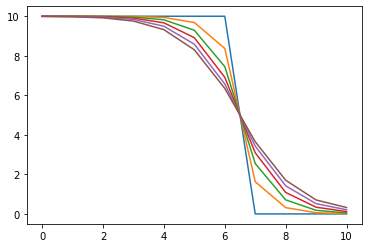

In [1121]:
start = time.time()
for _ in range(5):
    u.append(heat.forward(dt=30.0, # seconds
                          #source_term=1*[0.]+9*[0.]+1*[0.]
                          )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_imp = u

A = 
 [[ 1.3 -0.3  0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.3  1.6 -0.3  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.3  1.6 -0.3  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.3  1.6 -0.3  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.3  1.6 -0.3  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.3  1.6 -0.3  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.3  1.6 -0.3  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.3  1.6 -0.3  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.3  1.6 -0.3  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.3  1.6 -0.3]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.3  1.3]]

u = 
 [9.99037378 9.97416713 9.91885935 9.7557986  9.32069936 8.30285855
 6.34852181 3.65420193 1.70478756 0.70457595 0.32515599]

f = 
 [9.99523577 9.98589747 9.95118523 9.83741015 9.49552183 8.58380733
 6.57051675 3.43073027 1.42002674 0.51833845 0.21133   ]

Determinant = 78.80229868389988
Error =  1.7763568394002505e-15


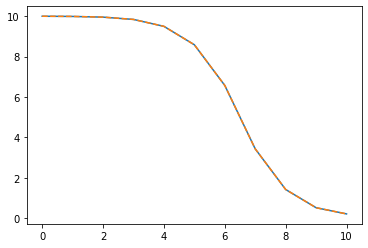

In [1122]:
print('A = \n', heat.A)
print()
print('u = \n', u[-1])
print()
print('f = \n', heat.f)
print()
print('Determinant =', np.linalg.det(heat.A))
print('Error = ', np.max(abs(heat.A.dot(u[-1])-heat.f)))

plt.plot(heat.A.dot(u[-1]))
plt.plot(heat.f, '--')

[9.99037378 9.97416713 9.91885935 9.7557986  9.32069936 8.30285855
 6.34852181 3.65420193 1.70478756 0.70457595 0.32515599]


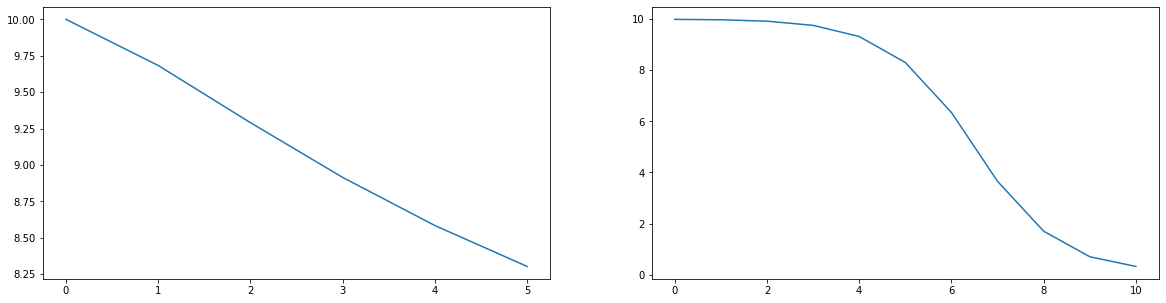

In [1123]:
print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_imp)[:,5])
axes[1].plot(u_imp[-1])

### Solve explicit

In [1124]:
heat = Heat(alpha = 0.0001, # Thermal diffusivity of Aluminium
            dx=0.1,
            N=11, 
            initial_condition = 4*[10.]+3*[10.]+4*[0.],
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            boundary_values = [0, 0],
            time_integration='explicit')

In [1125]:
print(f'Greatest time step explicit = {(heat.dx**2)/(2*heat.alpha):.2f}s')

Greatest time step explicit = 50.00s


In [1126]:
# Initialize u
u=[]
u.append(heat.u_previous.copy())  # Initial condition

Time step 1 => dt = 30.0s, r = 0.30, total time = 30.0s
Time step 2 => dt = 30.0s, r = 0.30, total time = 60.0s
Time step 3 => dt = 30.0s, r = 0.30, total time = 90.0s
Time step 4 => dt = 30.0s, r = 0.30, total time = 120.0s
Time step 5 => dt = 30.0s, r = 0.30, total time = 150.0s
0.0006649494171142578


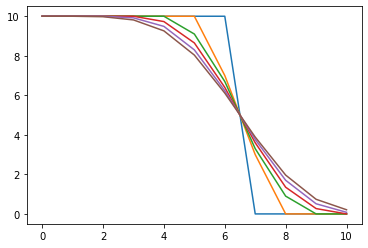

In [1127]:
start = time.time()
for _ in range(5):
    u.append(heat.forward(dt=30.0, # seconds
                          #source_term=4*[0.]+3*[0.]+4*[0.]
                          )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_exp = u

[10.     10.      9.9757  9.8137  9.2602  8.0362  6.1132  3.8868  1.9638
  0.7398  0.2106]
[9.99037378 9.97416713 9.91885935 9.7557986  9.32069936 8.30285855
 6.34852181 3.65420193 1.70478756 0.70457595 0.32515599]


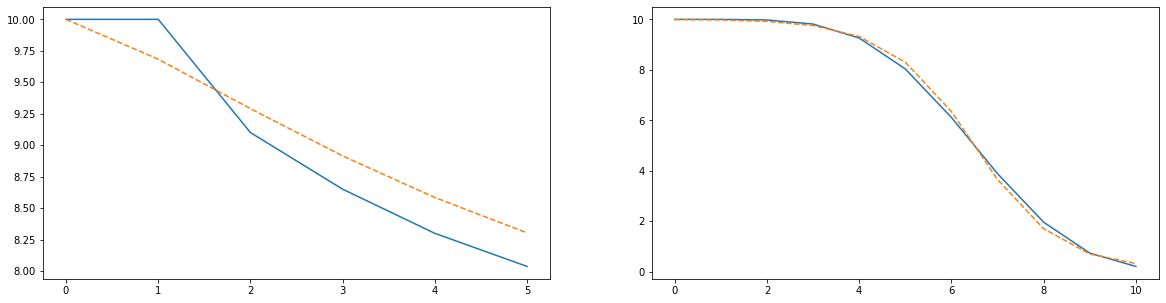

In [1128]:
print(u_exp[-1])
print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_exp)[:,5])
axes[0].plot(np.array(u_imp)[:,5],'--')
axes[1].plot(u_exp[-1])
axes[1].plot(u_imp[-1],'--')

### Solve Crank-Nicolson

In [1129]:
heat = Heat(alpha = 0.0001, # Thermal diffusivity of Aluminium
            dx=0.1,
            N=11, 
            initial_condition = 4*[10.]+3*[10.]+4*[0.],
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            boundary_values = [0, 0],
            time_integration='Crank-Nicolson')

In [1130]:
# Initialize u
u=[]
u.append(heat.u_previous.copy())  # Initial condition

Time step 1 => dt = 30.0s, r = 0.30, total time = 30.0s
Time step 2 => dt = 30.0s, r = 0.30, total time = 60.0s
Time step 3 => dt = 30.0s, r = 0.30, total time = 90.0s
Time step 4 => dt = 30.0s, r = 0.30, total time = 120.0s
Time step 5 => dt = 30.0s, r = 0.30, total time = 150.0s
0.001766204833984375


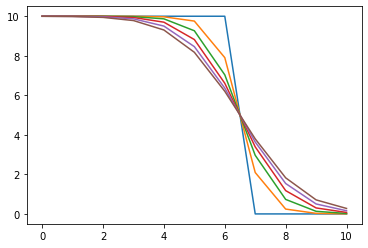

In [1131]:
start = time.time()
for _ in range(5):
    u.append(heat.forward(dt=30.0, # seconds
                          #source_term=1*[0.]+9*[0.]+1*[0.]
                          )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_cn = u

A = 
 [[ 1.15 -0.15  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.15  1.3  -0.15  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.15  1.3  -0.15  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.15  1.3  -0.15  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.15  1.3  -0.15  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.15  1.3  -0.15  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.15  1.3  -0.15  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.15  1.3  -0.15  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.15  1.3  -0.15  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -0.15  1.3  -0.15]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.15  1.15]]

u = 
 [9.99644633 9.98609508 9.94162032 9.78180012 9.30395751 8.17676648
 6.20417968 3.79652187 1.82621632 0.70983933 0.27655694]

f = 
 [9.99799902 9.99121361 9.95892214 9.82950349 9.40135977 8.30357585
 6.26944034 3.73091903 1.6981

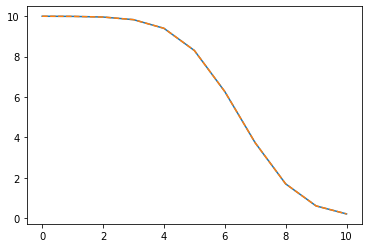

In [1132]:
print('A = \n', heat.A)
print()
print('u = \n', u[-1])
print()
print('f = \n', heat.f)
print()
print('Determinant =', np.linalg.det(heat.A))
print('Error = ', np.max(abs(heat.A.dot(u[-1])-heat.f)))

plt.plot(heat.A.dot(u[-1]))
plt.plot(heat.f, '--')

[10.     10.      9.9757  9.8137  9.2602  8.0362  6.1132  3.8868  1.9638
  0.7398  0.2106]
[9.99037378 9.97416713 9.91885935 9.7557986  9.32069936 8.30285855
 6.34852181 3.65420193 1.70478756 0.70457595 0.32515599]
[9.99644633 9.98609508 9.94162032 9.78180012 9.30395751 8.17676648
 6.20417968 3.79652187 1.82621632 0.70983933 0.27655694]


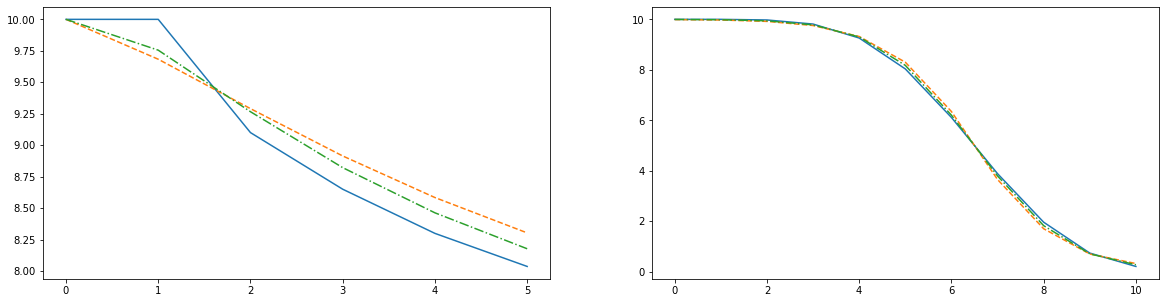

In [1133]:
print(u_exp[-1])
print(u_imp[-1])
print(u_cn[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_exp)[:,5])
axes[0].plot(np.array(u_imp)[:,5],'--')
axes[0].plot(np.array(u_cn)[:,5],'-.')
axes[1].plot(u_exp[-1])
axes[1].plot(u_imp[-1],'--')
axes[1].plot(u_cn[-1],'-.')